In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from ControlRF.train import *
from ControlRF.eval import eval_c
from ControlRF.viz.episodic_plot import *
from ControlRF.viz.animate import *
from ControlRF.viz.plot import *
from ControlRF.util import *
from core.systems import InvertedPendulum
import sys
import mosek
import numpy as np
np.set_printoptions(threshold=sys.maxsize)

In [2]:
system = InvertedPendulum(0.7,0.7)
system_est = InvertedPendulum(0.50,0.50)
system.lyap = AffineQuadCLF.build_care(system, Q=np.identity(2), R=np.identity(1))
system_est.lyap = AffineQuadCLF.build_care(system_est, Q=np.identity(2), R=np.identity(1))

system_est.alpha = 1 / max(la.eigvals(system_est.lyap.P))

# Nominal Controller Static Slacked
x_0 = np.array([3, 0.1])
system.qp_controller = QPController(system_est, system.m)
system.qp_controller.add_static_cost(np.identity(1))
system.qp_controller.add_stability_constraint(system_est.lyap, comp=lambda r: system_est.alpha * r, slacked=True, coeff = 1e3)



system.oracle_controller = QPController(system, system.m)
system.oracle_controller.add_static_cost(np.identity(1))
system.oracle_controller.add_stability_constraint(system.lyap, comp=lambda r: system_est.alpha * r, slacked=True, coeff = 1e3)


In [3]:
# system = InvertedPendulum(0.7,0.7)
# system_est = InvertedPendulum(0.50,0.5)
# system.lyap = AffineQuadCLF.build_care(system, Q=np.identity(2), R=np.identity(1))
# system_est.lyap = AffineQuadCLF.build_care(system_est, Q=np.identity(2), R=np.identity(1))

# system_est.alpha = 1 / max(la.eigvals(system_est.lyap.P))

# # Nominal Controller Static Slacked
# x_0 = np.array([2, 0.1])
# system.qp_controller = QPController(system_est, system.m)# Linearizing Controller
# controller_linear = FBLinController(system_est, LQRController(system_est, system.lyap.P, R=np.identity(1)))
# # controller_linear = LQRController(system, lyap.P, R=identity(1))

# # Nominal Controller Static Slacked
# controller = QPController(system_est, system.m)
# controller.add_regularizer(controller_linear, coeff=1)

# system.qp_controller.add_stability_constraint(system_est.lyap, comp=lambda r: system_est.alpha * r, slacked=True, coeff = 1e3)
# # plot_simulation(system, system_est.qp_controller, 'qp_controller', x_0, T=100, num_steps=1000)


# system.oracle_controller = QPController(system, system.m)
# system.oracle_controller.add_static_cost(np.identity(1))
# system.oracle_controller.add_stability_constraint(system.lyap, comp=lambda r: system_est.alpha * r, slacked=True, coeff = 1e3)

In [4]:
def plot_qp(func):
    ts = np.linspace(0, T, num_steps)
    qp_zs = func(system, system.qp_controller, x_0, T, num_steps)
    model_zs = func(system, system.oracle_controller, x_0, T, num_steps)
    fig, ax = plt.subplots()
    time = 0
    ax.plot(ts[time:], qp_zs[time:], "-", label="qp_controller")
    ax.plot(ts[time:], model_zs[time:], "k-.", label="oracle_controller")

    plt.show()
    plt.close()

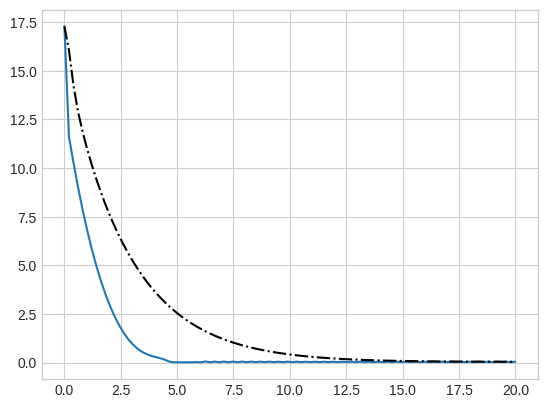

In [5]:
T = 20
num_steps = 100
epochs = 20

plot_qp(eval_c)

In [6]:
gps_names = ["ad_kernel", "adp_kernel", "ad_rf", "adp_rf"]

controllers, gps = train_episodic(system, system_est, x_0, epochs, T, num_steps, \
                                  gps_names, info=True, func=eval_c, sgm=1, slack='constant', D=1, coeff=1e5)

ad_kernel
training time for ad_kernel_gp is: 0.0020302811171859503
adp_kernel
training time for adp_kernel_gp is: 0.0010457970201969147
ad_rf
training time for ad_rf_gp is: 0.00021700398065149784
adp_rf
training time for adp_rf_gp is: 0.0001988180447369814


  0%|          | 0/20 [00:00<?, ?it/s]

ad_kernel
training time for ad_kernel_gp is: 0.0052145610097795725
adp_kernel
training time for adp_kernel_gp is: 0.0032040851656347513
ad_rf
training time for ad_rf_gp is: 0.00034535815939307213
adp_rf
training time for adp_rf_gp is: 0.00035630189813673496
iteration0:data size:198


  0%|          | 0/20 [00:33<?, ?it/s]


SolverError: Solver 'MOSEK' failed. Try another solver, or solve with verbose=True for more information.

In [ ]:
data = np.load('data/diff_from_oracle.npz')
print(data["gp_zs"].T)

[[9.37815786 2.21402973 1.95824354 2.37964228]
 [9.65732502 1.97871792 2.04060299 4.55940349]
 [9.79797685 1.81720236 1.6791719  5.50484979]
 [9.8581254  1.6968585  1.60268256 2.33673468]
 [9.89183513 1.60211803 1.5838209  6.66826586]
 [9.9136393  1.52468559 1.48537592 6.25622525]
 [9.92914461 1.45968855 1.41980873 4.45443477]
 [9.94091425 1.40408292 1.33750797 7.33618589]
 [9.95020073 1.35557473 1.28575202 8.13876722]
 [9.95701739 1.31275313 1.25679265 6.3263879 ]]


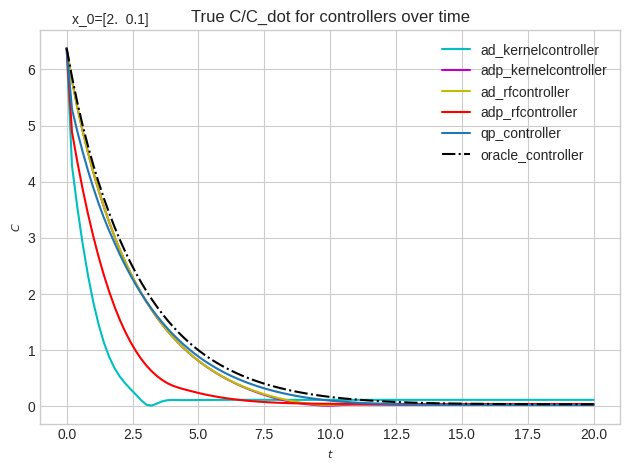

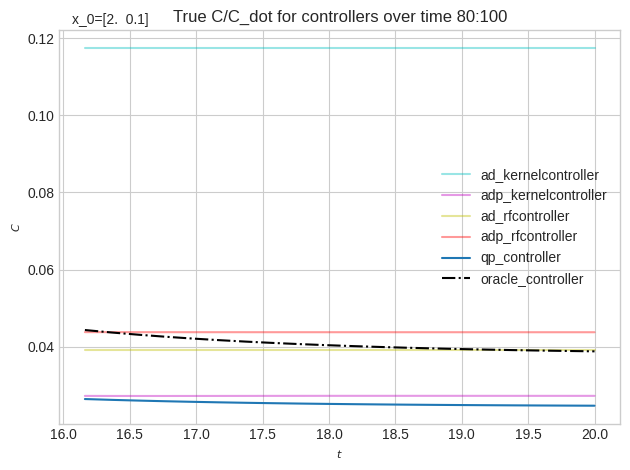

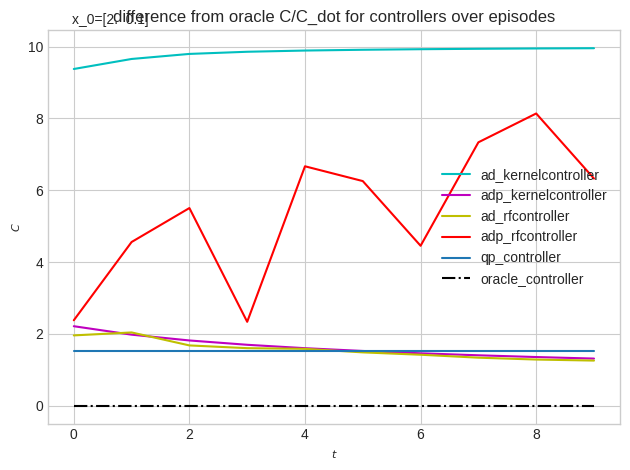

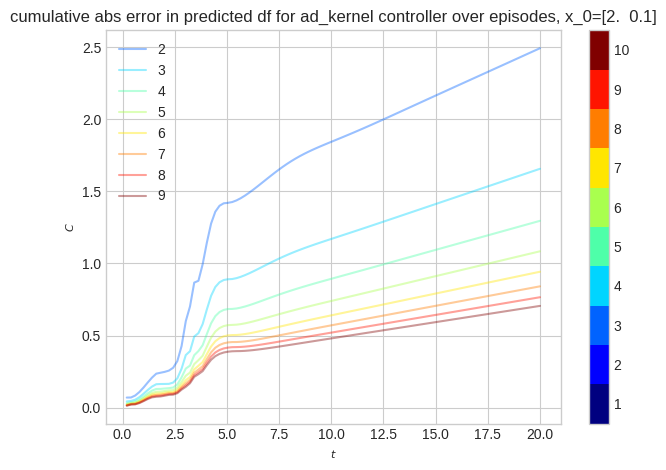

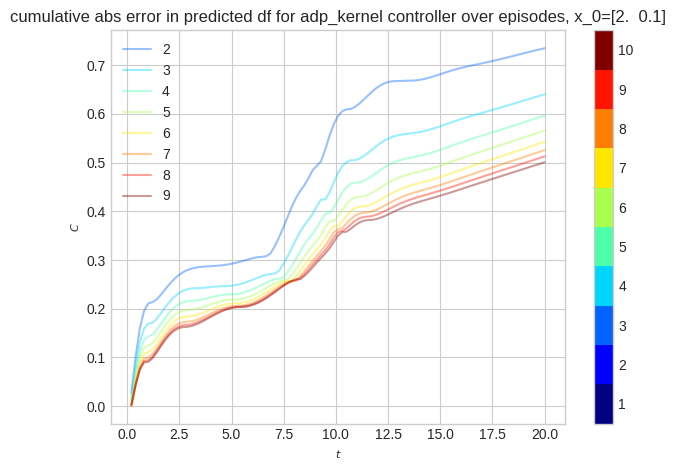

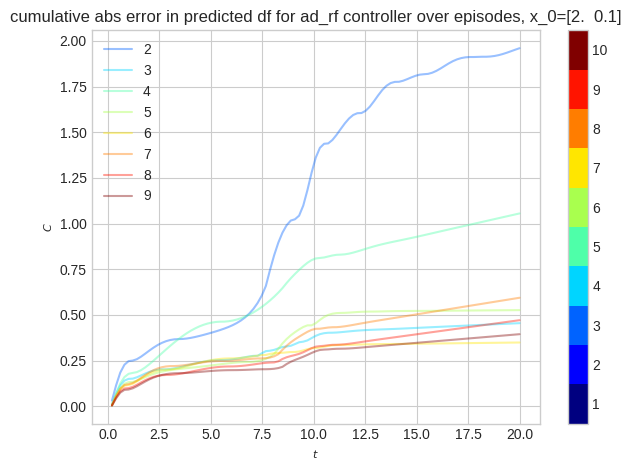

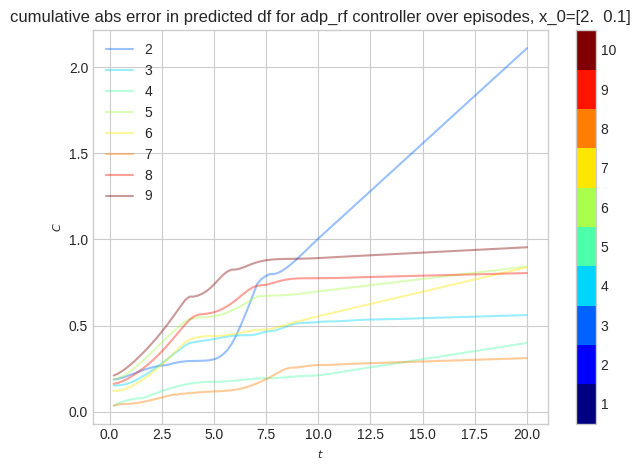

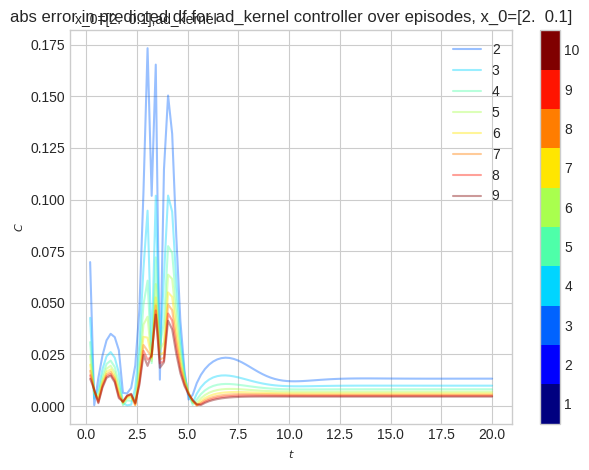

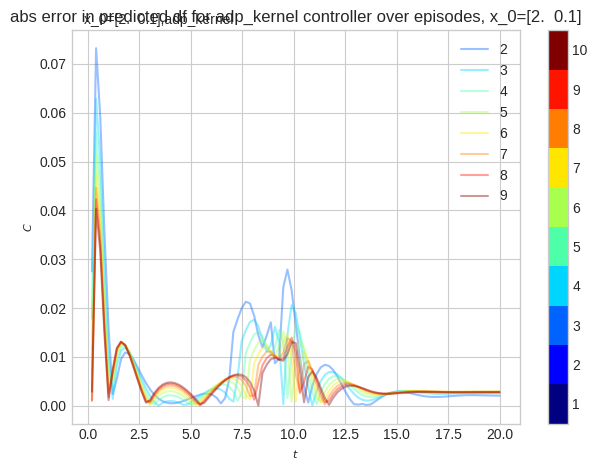

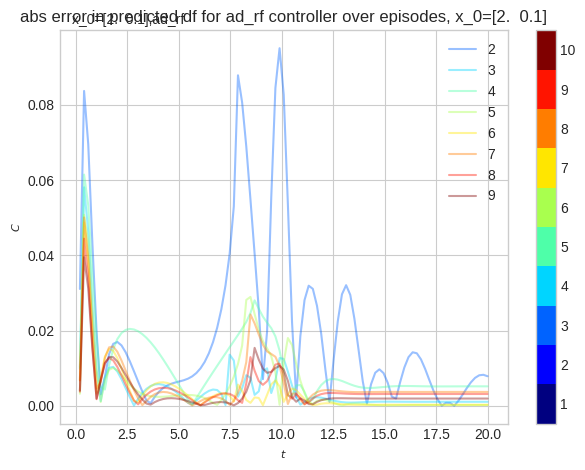

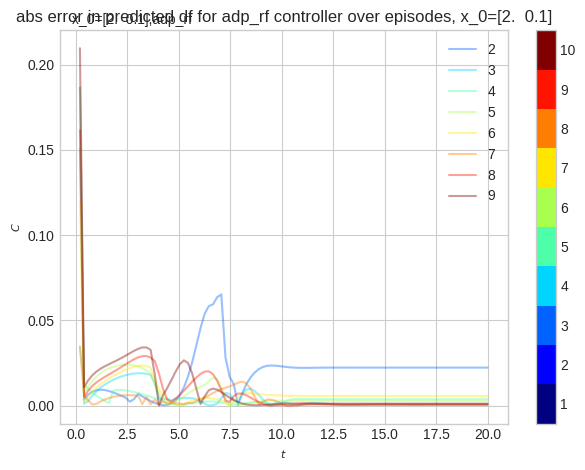

In [ ]:
path = 'data/eval_c.npz'
plot_info(x_0, controllers, path)
plot_info(x_0, controllers, 'data/diff_from_oracle.npz', diff=True)
# plot_predicted_vs_true_func(x_0, epochs, T)
episodic_plot_cum_predicted_vs_true_func(x_0, epochs, T, num_steps)
episodic_plot_predicted_vs_true_func(x_0, epochs, T, num_steps)

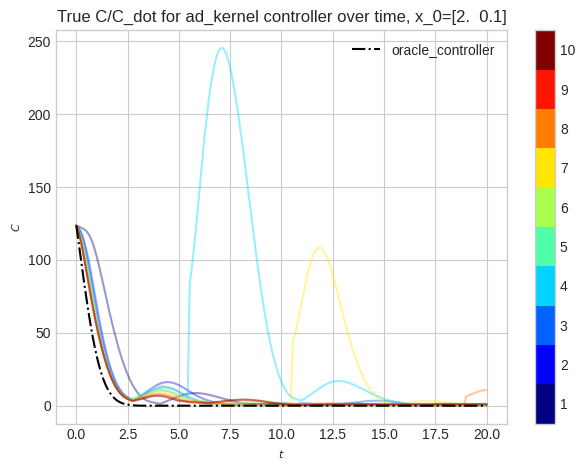

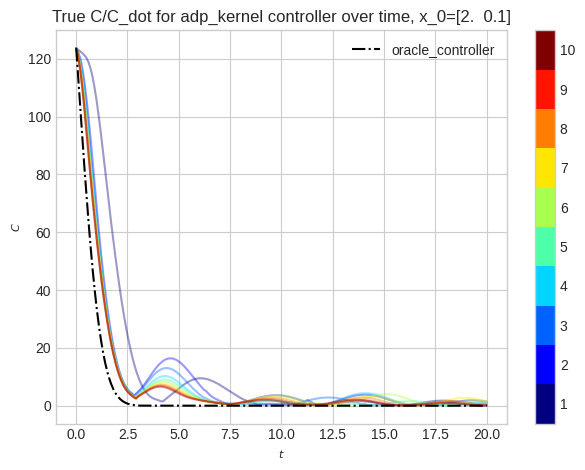

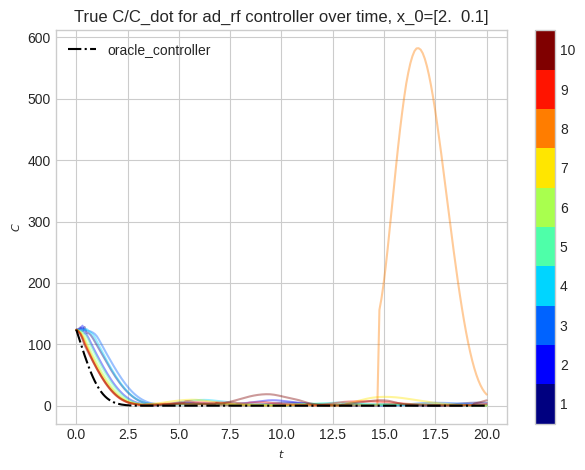

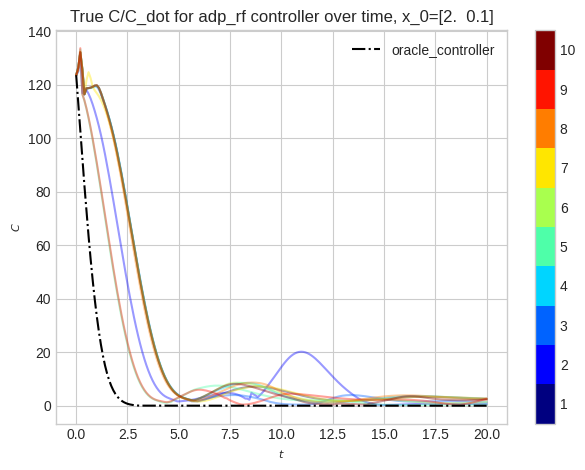

In [ ]:
episodic_plot_func_for_controller(x_0, epochs, path, gps_names)

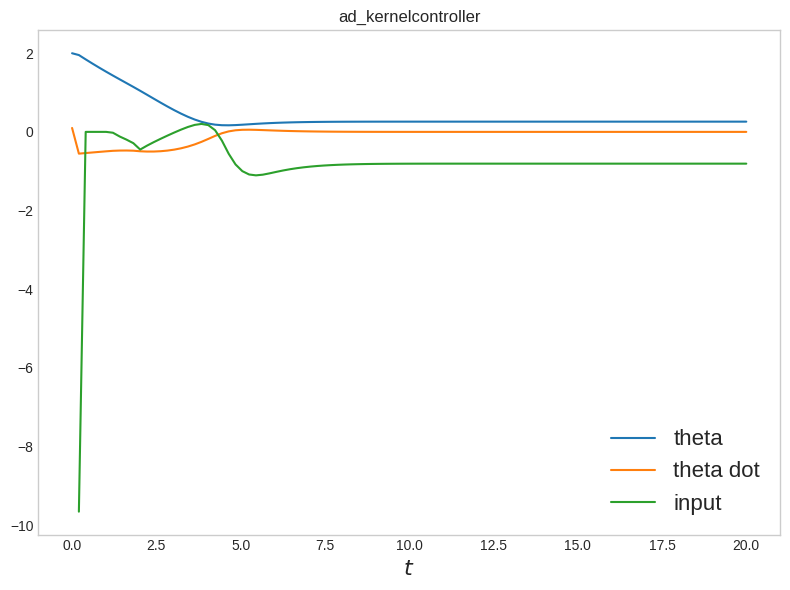

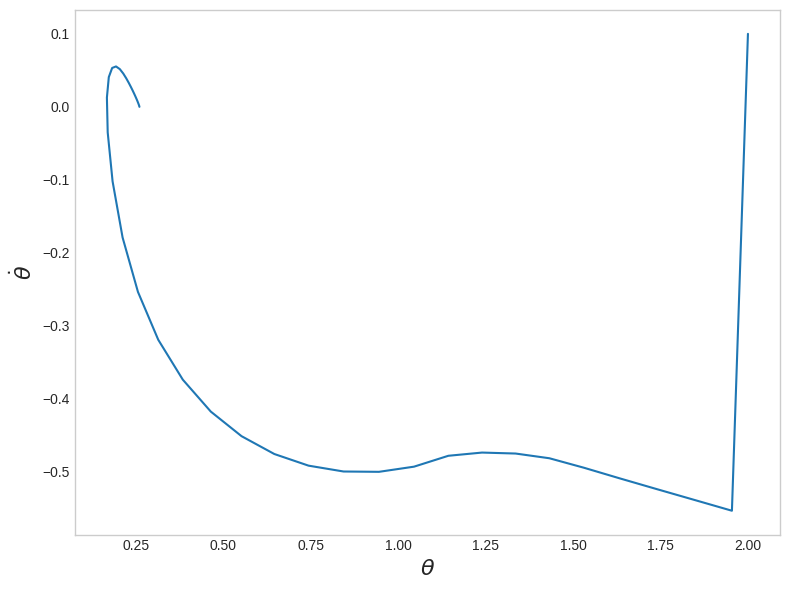

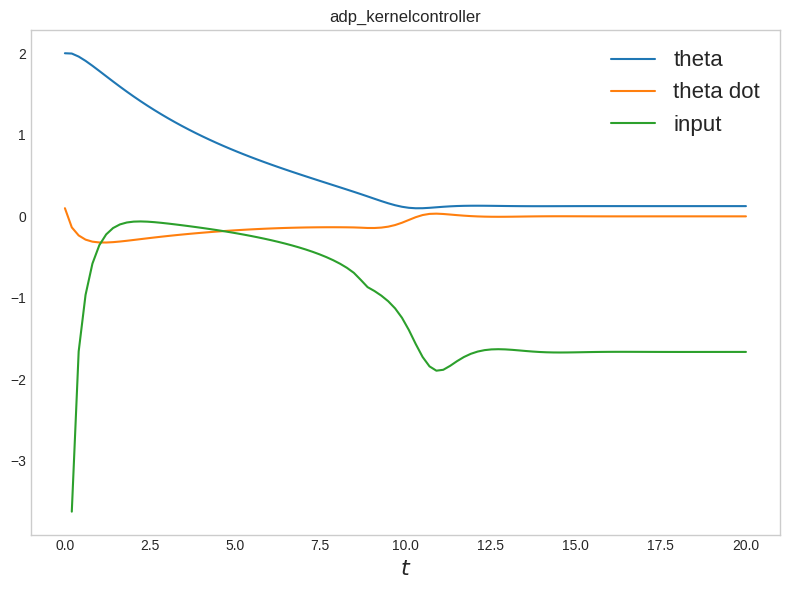

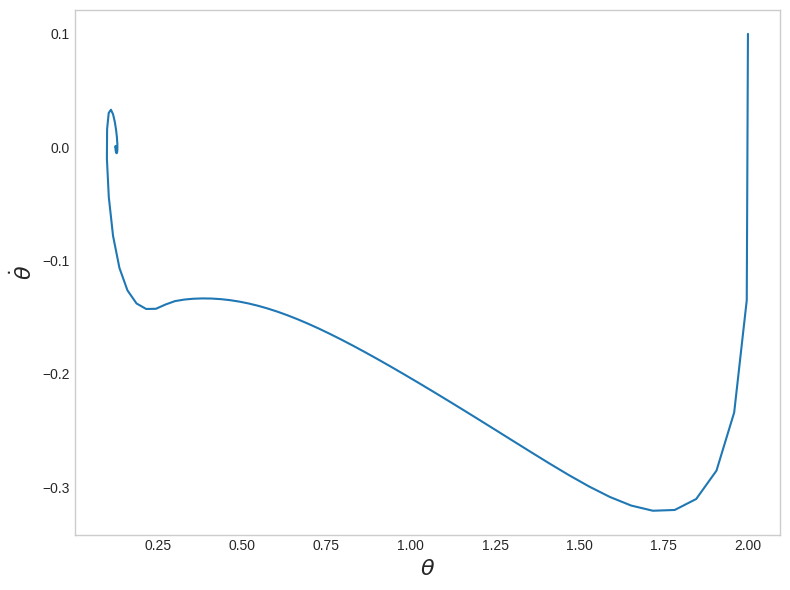

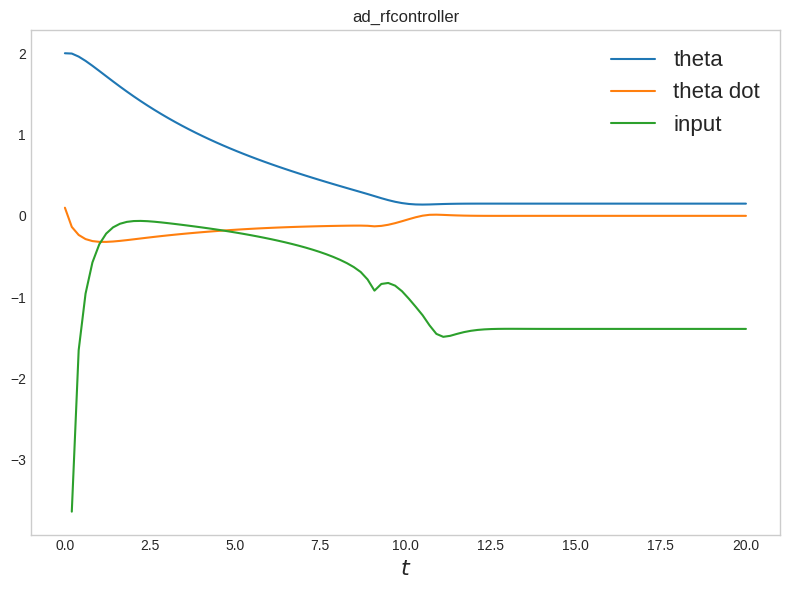

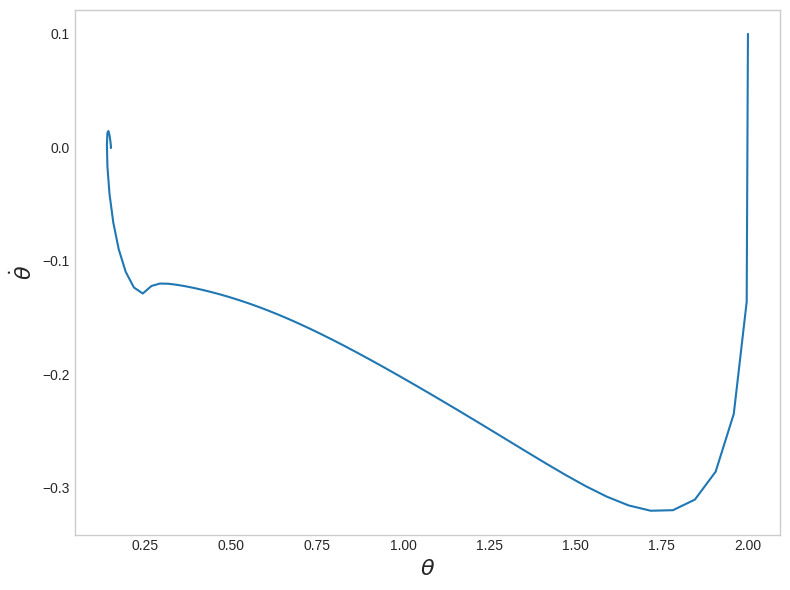

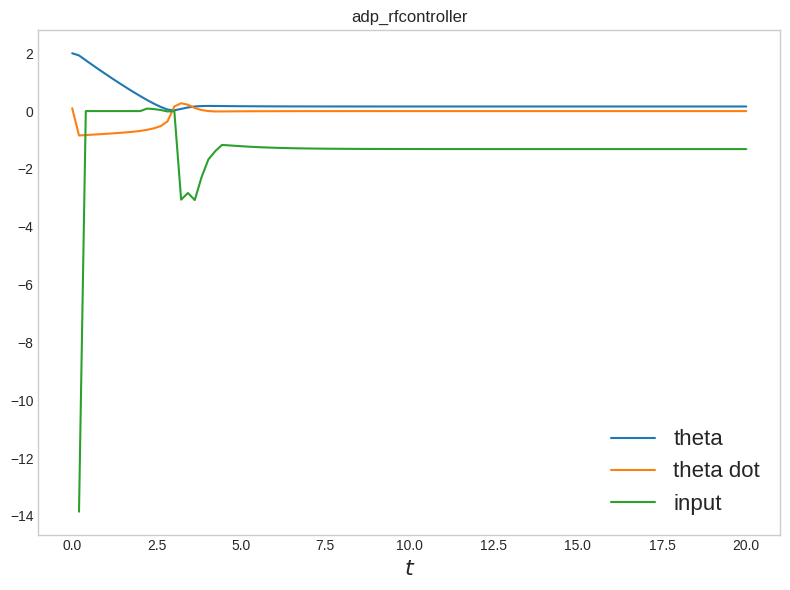

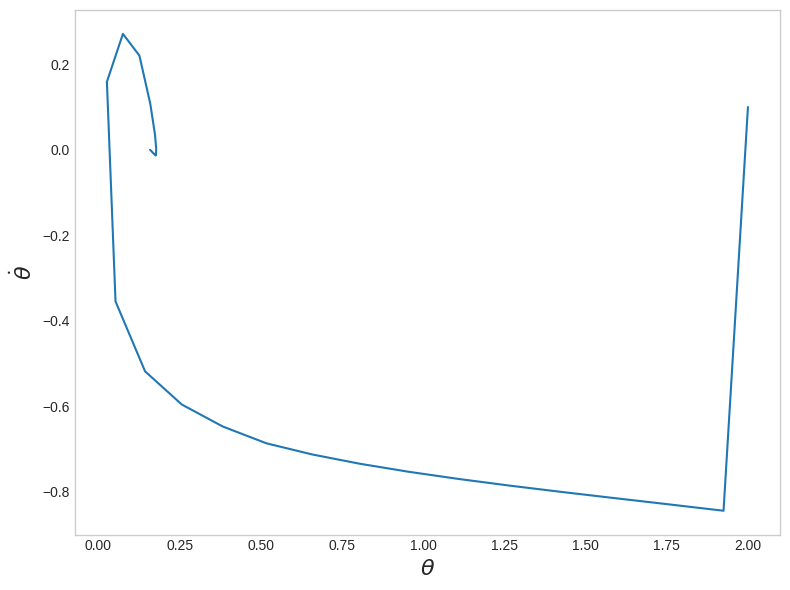

In [ ]:
for controller in controllers:
    plot_simulation(system, controller, x_0, T, num_steps)

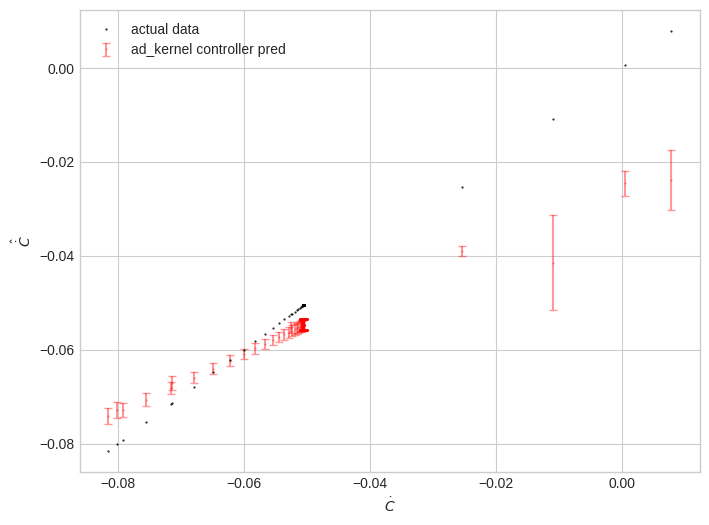

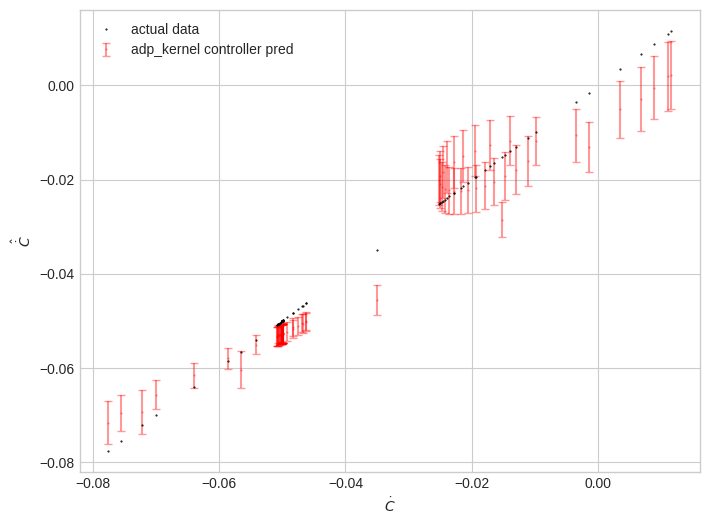

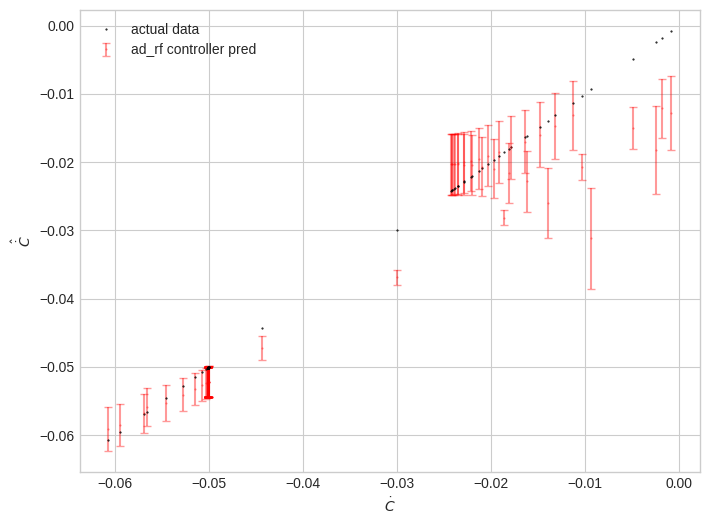

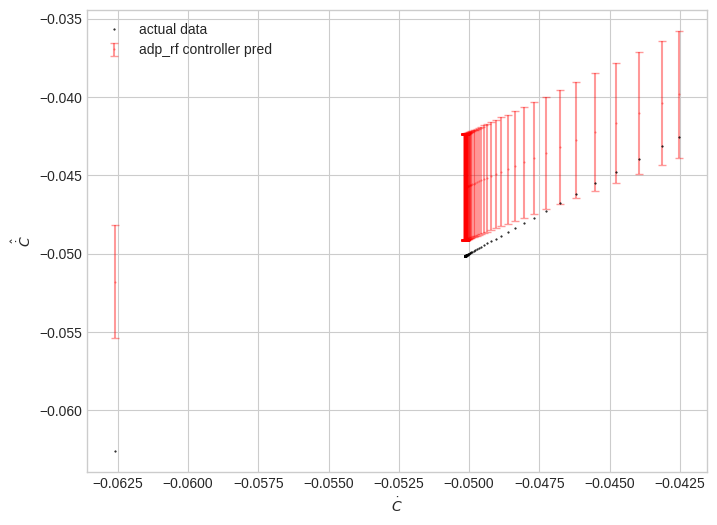

In [ ]:
for gp,controller in zip(gps, controllers):
    plot_closed_loop_errorbar(
    system, system_est, controller, gp, x_0, T, num_steps, cut_off=20)